<a href="https://colab.research.google.com/github/shivanisingh28/1104102_1dconv_reg/blob/master/assgnmt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import torch
from torch.nn import Conv1d #since we're inputing 1D row of data
from torch.nn import MaxPool1d #max pooling layer
from torch.nn import Flatten
from torch.nn import Linear
from torch.nn.functional import relu #activation function
from torch.utils.data import DataLoader, TensorDataset #to work with datasets


In [58]:
dataset = pd.read_csv('/content/drive/My Drive/housing.csv')
dataset = dataset.dropna()

print("Here are the first 10 rows of the dataset:")
dataset.head(10)

Here are the first 10 rows of the dataset:


longitude  latitude  ...  median_house_value  ocean_proximity
0    -122.23     37.88  ...            452600.0         NEAR BAY
1    -122.22     37.86  ...            358500.0         NEAR BAY
2    -122.24     37.85  ...            352100.0         NEAR BAY
3    -122.25     37.85  ...            341300.0         NEAR BAY
4    -122.25     37.85  ...            342200.0         NEAR BAY
5    -122.25     37.85  ...            269700.0         NEAR BAY
6    -122.25     37.84  ...            299200.0         NEAR BAY
7    -122.25     37.84  ...            241400.0         NEAR BAY
8    -122.26     37.84  ...            226700.0         NEAR BAY
9    -122.25     37.84  ...            261100.0         NEAR BAY

[10 rows x 10 columns]

Plot for each feature of the dataset:


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5a612270f0>,
      dtype=object)

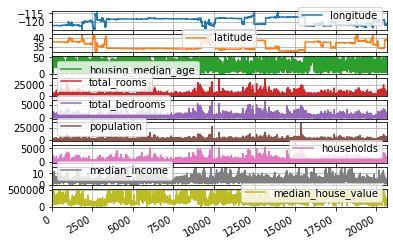

In [59]:
# plot each feature of the dataset on separate sub-plots
print("Plot for each feature of the dataset:")
dataset.plot(subplots = True, grid = True)

In [0]:
Y= dataset['median_house_value']
X= dataset.loc[:,'longitude':'median_income']

#split into training and testing
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=2003)

#convert the datasets to numpy arrays to work with PyTorch model

x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()

x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

**CREATING MODEL**

In [0]:
import torch
from torch.nn import Conv1d #since we're inputing 1D row of data
from torch.nn import MaxPool1d #max pooling layer
from torch.nn import Flatten
from torch.nn import Linear
from torch.nn.functional import relu #activation function
from torch.utils.data import DataLoader, TensorDataset #to work with datasets

*Defining* our model

In [0]:
class CnnRegressor(torch.nn.Module):
  #define the initialization method
  def __init__(self,batch_size,inputs,outputs):

    #initialize the superclass and store the parameters
    super(CnnRegressor,self).__init__()
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs

    #Define input layer (inout channels,output channels,kernel size)
    self.input_layer = Conv1d(inputs,batch_size,1)

    self.max_pooling_layer = MaxPool1d(1)

    #another convolutional layer
    self.conv_layer = Conv1d(batch_size,128,1)

    self.flatten_layer = Flatten()

    self.linear_layer = Linear(128,64)

    #defining the output layer
    self.output_layer = Linear(64,outputs)

  def feed(self,input):
    #reshape the entry so it can fit in the input layer. Although we are using 
    #1D but it expects a 3D wherein the other values except 1D data is empty
    input = input.reshape((self.batch_size,self.inputs,1))
    output = relu(self.input_layer(input))

    output = self.max_pooling_layer(output)

    output = relu(self.conv_layer(output))

    output = self.flatten_layer(output)

    output = self.linear_layer(output)

    output = self.output_layer(output)
    return output

MODEL TRAINING

In [84]:
from torch.optim import SGD,Rprop,Adam

from torch.nn import L1Loss
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score 

In [85]:
#define the batch size we'd like to use
batch_size = 64

#(batch_size,X columns, Y columns)
model = CnnRegressor(batch_size,X.shape[1],1)

#set the model to use the GPU for processing
model.cuda()

CnnRegressor(
  (input_layer): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

Lets create a method for running the batches of data through out model

In [0]:
#This method will return the average L1 loss and R^2 score of the passed model 
#on the passed Dataloader

def model_loss(model,dataset,train=False,optimizer=None):

  performance = L1Loss()
  mse = 
  score_metric = R2Score()
  avg_loss=0
  avg_score=0
  count=0
  for input,output in iter(dataset):
    predictions = model.feed(input)

    loss = performance(predictions,output)

    score_metric.update([predictions,output])
    score = score_metric.compute()

    if (train):
      optimizer.zero_grad() #clear nay errors so they dont accumulate

      loss.backward() #compute the gradients for our optimizer

      #use the optimizer o update the models parameteres based on the gradients
      optimizer.step()

    #Store the loss and update the counter
    avg_loss +=loss.item()
    avg_score +=score
    count += 1

  return avg_loss/count,avg_score/count

In [92]:
#number of epochs to train
epochs = 450 #better performance with increased number of epochs 

optimizer = Adam(model.parameters() ,lr=0.001)

inputs = torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0],1)).cuda().float()

tensor = TensorDataset(inputs,outputs)
loader = DataLoader(tensor,batch_size,shuffle=True, drop_last=True)

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
for epoch in range(epochs):

  avg_loss,avg_r2_score = model_loss(model,loader,train=True,optimizer=optimizer)

print("Epoch" + str(epoch + 1) + ":\n\tLoss = " + str(avg_loss) + "\n\tR^2 Score = " + str(avg_r2_score))
end.record()

torch.cuda.synchronize()
print("Inference Time: "+str(start.elapsed_time(end)))

Epoch450:
	Loss = 40357.11631165919
	R^2 Score = 0.7341403406262607
Inference Time: 279815.75


In [88]:
#using the tseting set instead of testing

inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0],1)).cuda().float()

tensor = TensorDataset(inputs,outputs)
loader = DataLoader(tensor,batch_size,shuffle=True, drop_last=True)

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()
avg_loss, avg_r2_score = model_loss(model, loader)
end.record()

torch.cuda.synchronize()
print("The model's L1 loss is: " + str(avg_loss))
print("The model's R^2 score is: " + str(avg_r2_score))

print("Inference Time: "+str(start.elapsed_time(end)))

The model's L1 loss is: 47962.753248355264
The model's R^2 score is: 0.6343531327543194
Inference Time124.78451538085938
